In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('train_data.csv.csv_fixed')

In [3]:
test = pd.read_csv('test_data.csv.csv_fixed')

# EDA

In [4]:
train.head()

,user_id,channel,age,os,gender,country,customer
0,100000,00 Organic,20,ios,female,GB,0
1,100001,00 Organic,30,ios,female,US,1
2,100002,31 OUTBRAIN,35,ios,female,DE,0
3,100003,00 Organic,26,android,female,US,0
4,100004,32 Taboola,55,ios,female,US,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82908 entries, 0 to 82907
Data columns (total 7 columns):
user_id     82908 non-null int64
channel     82908 non-null object
age         82908 non-null int64
os          82908 non-null object
gender      82908 non-null object
country     82908 non-null object
customer    82908 non-null int64
dtypes: int64(3), object(4)
memory usage: 4.4+ MB


In [6]:
train.describe()

,user_id,age,customer
count,82908.000000,82908.000000,82908.000000
mean,141453.500000,31.151734,0.297848
std,23933.622396,11.596902,0.457315
min,100000.000000,12.000000,0.000000
25%,120726.750000,22.000000,0.000000
50%,141453.500000,29.000000,0.000000
75%,162180.250000,38.000000,1.000000
max,182907.000000,96.000000,1.000000


In [7]:
train['channel'].unique()

array(['00 Organic', '31 OUTBRAIN', '32 Taboola', '22 Adwords (Search)',
       '42 Adcolony', '12 PINTEREST', '11 FB', '41 Youtube',
       '61 Web/Content', '95 LAT', '69 Others', '21 ASA', '62 Social Media'], dtype=object)

In [8]:
train['country'].unique()

array(['GB', 'US', 'DE', 'MX', 'ES', 'AU', 'CA', 'FR'], dtype=object)

In [9]:
train['os'].unique()

array(['ios', 'android'], dtype=object)

### Missing values

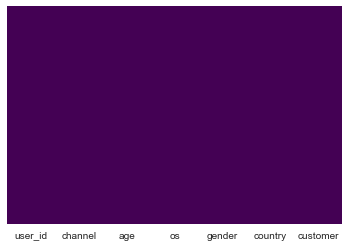

In [10]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')
# Result - no missing values

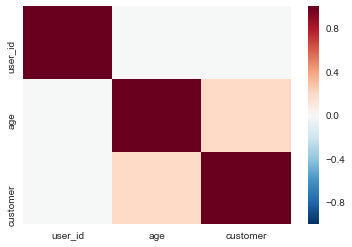

In [12]:
# Indicates correlation between age and if customer converted or not
sns.heatmap(train.corr())

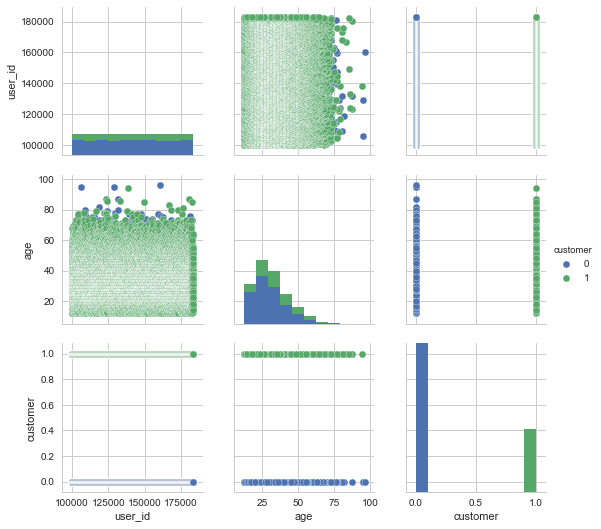

In [13]:
# Slight distinction that younger customers were more likely to convert
sns.pairplot(data=train,hue='customer')

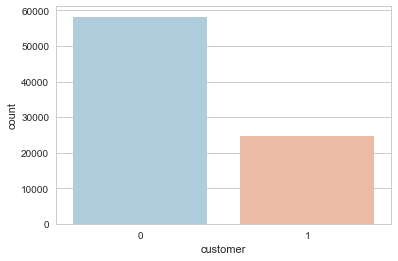

In [11]:
# Imbalanced dataset - need to create subsample
sns.set_style('whitegrid')
sns.countplot(x='customer',data=train,palette='RdBu_r')

In [9]:
np.count_nonzero(train['customer'])

24694

# Data transformation

### Get dummy variables

In [3]:
channel = pd.get_dummies(train['channel'])
os = pd.get_dummies(train['os'], drop_first=True)
gender = pd.get_dummies(train['gender'], drop_first=True)
country = pd.get_dummies(train['country'])

In [4]:
train.drop(['channel','os','gender','country'],axis=1,inplace=True)

In [5]:
# add dummy variable encoding to training matrix
train = pd.concat([train,channel,os,gender,country],axis=1)

In [7]:
train.head()

,user_id,age,customer,00 Organic,11 FB,12 PINTEREST,21 ASA,22 Adwords (Search),31 OUTBRAIN,32 Taboola,...,ios,male,AU,CA,DE,ES,FR,GB,MX,US
0,100000,20,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,100001,30,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,100002,35,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
3,100003,26,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,100004,55,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82908 entries, 0 to 82907
Data columns (total 26 columns):
user_id                82908 non-null int64
age                    82908 non-null int64
customer               82908 non-null int64
00 Organic             82908 non-null uint8
11 FB                  82908 non-null uint8
12 PINTEREST           82908 non-null uint8
21 ASA                 82908 non-null uint8
22 Adwords (Search)    82908 non-null uint8
31 OUTBRAIN            82908 non-null uint8
32 Taboola             82908 non-null uint8
41 Youtube             82908 non-null uint8
42 Adcolony            82908 non-null uint8
61 Web/Content         82908 non-null uint8
62 Social Media        82908 non-null uint8
69 Others              82908 non-null uint8
95 LAT                 82908 non-null uint8
ios                    82908 non-null uint8
male                   82908 non-null uint8
AU                     82908 non-null uint8
CA                     82908 non-null uint8
DE         

## Create subsamble for equal distribution

In [6]:
# Get all customers who converted
converted_customers_subsample = train[train['customer'] == 1]

In [7]:
%%time
# Get customers who didn't convert, so that we have exact 50/50 split
for i in range(0,train.shape[0]):
    if(converted_customers_subsample.shape[0] == 49388):
        break
    if(train['customer'][i] == 0):
        converted_customers_subsample = converted_customers_subsample.append(train.loc[i], ignore_index=True)

CPU times: user 1min 21s, sys: 47 s, total: 2min 8s
Wall time: 2min 9s


In [8]:
converted_customers_subsample['customer'].describe()

count    49388.000000
mean         0.500000
std          0.500005
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: customer, dtype: float64

In [9]:
# Randomly shuffle dataframe
converted_customers_subsample = converted_customers_subsample.sample(frac=1).reset_index(drop=True)

# Apply Standard Scaler to age

In [10]:
age = converted_customers_subsample['age'].values.reshape(49388,1)

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(age)
scaled_data = scaler.transform(age)

/Users/jzawadzki/anaconda/envs/p3env/lib/python3.5/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [12]:
converted_customers_subsample['age'] = scaled_data

In [168]:
converted_customers_subsample.head()

,user_id,age,customer,00 Organic,11 FB,12 PINTEREST,21 ASA,22 Adwords (Search),31 OUTBRAIN,32 Taboola,...,ios,male,AU,CA,DE,ES,FR,GB,MX,US
0,131970,1.574814,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,1
1,113326,0.487522,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,106546,-0.348856,0,0,0,1,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
3,181920,-0.934321,1,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
4,109096,2.411193,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### Prepare train_test_split

In [14]:
import scipy.sparse as sp
from sklearn.model_selection import train_test_split

X = converted_customers_subsample.drop(['user_id', 'customer'], axis=1)
y = converted_customers_subsample['customer']
X_sp = sp.csr_matrix(X)
X_tr, X_te, y_tr, y_te = train_test_split(X_sp, y, test_size=0.2)


# Logistic regression - GridSearchCV to find optimal parameters

In [172]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score

parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100], 'solver':['saga'], 'max_iter':[5000], 'n_jobs':[-1]} 
lr_gscv = GridSearchCV(LogisticRegression(), parameters, n_jobs=-1, cv=3, verbose=2)
lr_gscv.fit(X_tr, y_tr)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=0.001, max_iter=5000, solver=saga, n_jobs=-1 ..................
[CV] C=0.001, max_iter=5000, solver=saga, n_jobs=-1 ..................
[CV] C=0.001, max_iter=5000, solver=saga, n_jobs=-1 ..................
[CV] C=0.01, max_iter=5000, solver=saga, n_jobs=-1 ...................
[CV] C=0.01, max_iter=5000, solver=saga, n_jobs=-1 ...................
[CV] C=0.01, max_iter=5000, solver=saga, n_jobs=-1 ...................
[CV] C=0.1, max_iter=5000, solver=saga, n_jobs=-1 ....................
[CV] C=0.1, max_iter=5000, solver=saga, n_jobs=-1 ....................
[CV] ... C=0.001, max_iter=5000, solver=saga, n_jobs=-1, total=   0.2s
[CV] C=0.1, max_iter=5000, solver=saga, n_jobs=-1 ....................
[CV] ... C=0.001, max_iter=5000, solver=saga, n_jobs=-1, total=   0.2s
[CV] C=1, max_iter=5000, solver=saga, n_jobs=-1 ......................
[CV] ... C=0.001, max_iter=5000, solver=saga, n_jobs=-1, total=   0.3s
[CV] C=1, max_ite

[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    2.3s remaining:    0.9s


[CV] ..... C=0.1, max_iter=5000, solver=saga, n_jobs=-1, total=   2.6s
[CV] ..... C=0.1, max_iter=5000, solver=saga, n_jobs=-1, total=   2.8s
[CV] ....... C=1, max_iter=5000, solver=saga, n_jobs=-1, total=   2.8s
[CV] ....... C=1, max_iter=5000, solver=saga, n_jobs=-1, total=   3.8s
[CV] ....... C=1, max_iter=5000, solver=saga, n_jobs=-1, total=   4.8s


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    5.2s finished


CPU times: user 1.42 s, sys: 102 ms, total: 1.52 s
Wall time: 6.68 s


In [173]:
lr_gscv.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [174]:
lr_gscv.best_score_

0.59329283725639081

### Plot train test error

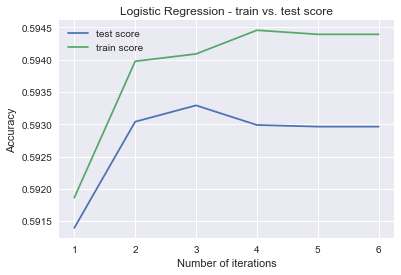

In [175]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot(range(1,7),lr_gscv.cv_results_['mean_test_score'], label='test score')
plt.plot(range(1,7),lr_gscv.cv_results_['mean_train_score'], label='train score')
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.title('Logistic Regression - train vs. test score')
plt.legend(loc='best')
plt.show()

# Cross validation

In [176]:
%%time
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)
predicted_lr = cross_val_predict(lr_model, X_te, y_te, cv=5, n_jobs=-1)
print(accuracy_score(y_te, predicted_lr))
print(classification_report(y_te, predicted_lr))

0.605183235473
             precision    recall  f1-score   support

          0       0.60      0.67      0.63      4980
          1       0.62      0.53      0.57      4898

avg / total       0.61      0.61      0.60      9878

CPU times: user 68.3 ms, sys: 40.8 ms, total: 109 ms
Wall time: 709 ms


# Confusion Matrix

In [30]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[3361 1619]
 [2281 2617]]
Normalized confusion matrix
[[ 0.67  0.33]
 [ 0.47  0.53]]


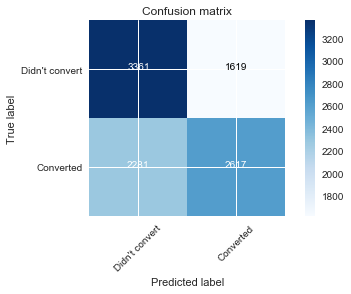

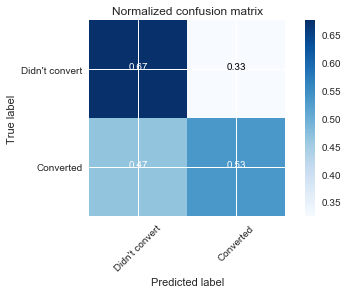

In [177]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = ["Didn't convert", "Converted"]
cnf_matrix = confusion_matrix(y_te, predicted_lr)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Gradient Boosted Trees - GridSearchCV to find optimal parameters

In [178]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, accuracy_score

gbt = ensemble.GradientBoostingClassifier()
parameters = {'n_estimators':[10,100,1000],'max_depth':[5,10,15], 'max_features':['sqrt','log2']} 
gbt_gscv = GridSearchCV(gbt, parameters, n_jobs=-1, cv=3, verbose=3)
gbt_gscv.fit(X_tr, y_tr)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] n_estimators=10, max_depth=5, max_features=sqrt .................
[CV] n_estimators=10, max_depth=5, max_features=sqrt .................
[CV] n_estimators=10, max_depth=5, max_features=sqrt .................
[CV] n_estimators=100, max_depth=5, max_features=sqrt ................
[CV] n_estimators=100, max_depth=5, max_features=sqrt ................
[CV] n_estimators=100, max_depth=5, max_features=sqrt ................
[CV] n_estimators=1000, max_depth=5, max_features=sqrt ...............
[CV] n_estimators=1000, max_depth=5, max_features=sqrt ...............
[CV]  n_estimators=10, max_depth=5, max_features=sqrt, score=0.590387973578316, total=   0.2s
[CV]  n_estimators=10, max_depth=5, max_features=sqrt, score=0.5934391373680613, total=   0.2s
[CV]  n_estimators=10, max_depth=5, max_features=sqrt, score=0.588078967350038, total=   0.2s
[CV] n_estimators=1000, max_depth=5, max_features=sqrt ...............
[CV] n_estimators

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.9s


[CV]  n_estimators=100, max_depth=10, max_features=sqrt, score=0.5729688686408504, total=   8.0s
[CV] n_estimators=1000, max_depth=10, max_features=sqrt ..............
[CV]  n_estimators=1000, max_depth=5, max_features=sqrt, score=0.5823842065299925, total=  15.5s
[CV]  n_estimators=1000, max_depth=5, max_features=sqrt, score=0.5832637254157491, total=  15.4s
[CV] n_estimators=1000, max_depth=10, max_features=sqrt ..............
[CV] n_estimators=1000, max_depth=10, max_features=sqrt ..............
[CV]  n_estimators=1000, max_depth=5, max_features=sqrt, score=0.5819603674739959, total=  15.7s
[CV] n_estimators=10, max_depth=10, max_features=log2 ................
[CV]  n_estimators=10, max_depth=10, max_features=log2, score=0.5843140232328601, total=   1.0s
[CV] n_estimators=10, max_depth=10, max_features=log2 ................
[CV]  n_estimators=1000, max_depth=5, max_features=log2, score=0.5809415337889142, total=  15.6s
[CV] n_estimators=10, max_depth=10, max_features=log2 ..........

[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  5.5min finished


CPU times: user 1.86 s, sys: 278 ms, total: 2.13 s
Wall time: 5min 33s


In [179]:
gbt_gscv.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [180]:
gbt_gscv.best_score_

0.595292331055429

### Plot train test error

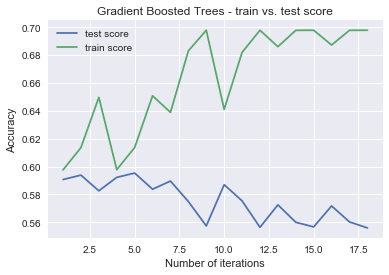

In [181]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot(range(1,19),gbt_gscv.cv_results_['mean_test_score'], label='test score')
plt.plot(range(1,19),gbt_gscv.cv_results_['mean_train_score'], label='train score')
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.title('Gradient Boosted Trees - train vs. test score')
plt.legend(loc='best')
plt.show()

# Cross validation

In [197]:
%%time
from sklearn import ensemble
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

gbt_model = gbt_gscv.best_estimator_
predicted_gbt = cross_val_predict(gbt_model, X_te, y_te, cv=5, n_jobs=-1)
print(accuracy_score(y_te, predicted_gbt))
print(classification_report(y_te, predicted_gbt))

0.595768374165
             precision    recall  f1-score   support

          0       0.59      0.65      0.62      4980
          1       0.60      0.54      0.57      4898

avg / total       0.60      0.60      0.59      9878

CPU times: user 69.5 ms, sys: 42 ms, total: 112 ms
Wall time: 616 ms


# Confusion Matrix

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[3253 1727]
 [2250 2648]]
Normalized confusion matrix
[[ 0.65  0.35]
 [ 0.46  0.54]]


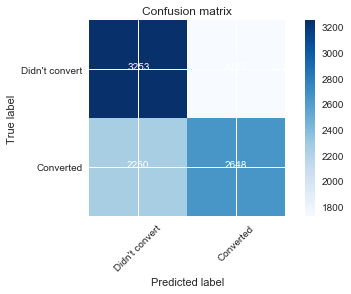

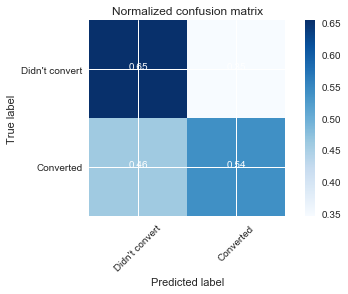

In [185]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = ["Didn't convert", "Converted"]
cnf_matrix = confusion_matrix(y_te, predicted_gbt)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# SVM

In [186]:
%%time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'C': [0.01,0.1,1,10], 'gamma': [1,0.1,0.01,0.001], 'kernel': ['rbf']}
gscv_svm = GridSearchCV(SVC(), parameters, refit=True, verbose=3, n_jobs=-1)
gscv_svm.fit(X_tr,y_tr)

print(gscv_svm.best_estimator_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................
[CV]  C=0.01, gamma=0.1, kernel=rbf, score=0.5935008731303621, total= 1.1min
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................
[CV]  C=0.01, gamma=0.1, kernel=rbf, score=0.5947300478396234, total= 1.1min
[CV] C=0.01, gamma=0.001, kernel=rbf .................................
[CV]  C=0.01, gamma=0.1, kernel=rbf, score=0.5856492027334852, total= 1.1mi

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.3min


[CV]  C=0.1, gamma=0.01, kernel=rbf, score=0.587243735763098, total= 1.2min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV]  C=0.1, gamma=0.01, kernel=rbf, score=0.5941841925442259, total= 1.2min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.5986027792543094, total= 1.2min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV]  C=0.1, gamma=0.01, kernel=rbf, score=0.5965525096818285, total= 1.2min
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.5894457099468489, total= 1.2min
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV]  C=0.1, gamma=0.001, kernel=rbf, score=0.5839787395596051, total= 1.2min
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV]  C=0.1, gamma=0.001, kernel=rbf, score=0.5861362083364968, total= 1.2min
[CV] C=1, gamma=0.01, kernel=rbf ...

[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 11.0min finished


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
CPU times: user 59.7 s, sys: 2.08 s, total: 1min 1s
Wall time: 12min 2s


In [198]:
gscv_svm.best_score_

0.59564667172867625

### Plot train test error

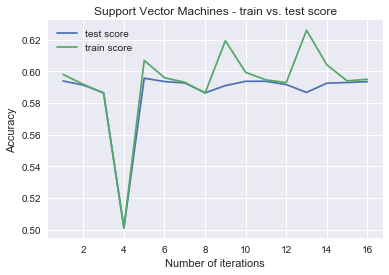

In [188]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot(range(1,17),gscv_svm.cv_results_['mean_test_score'], label='test score')
plt.plot(range(1,17),gscv_svm.cv_results_['mean_train_score'], label='train score')
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.title('Support Vector Machines - train vs. test score')
plt.legend(loc='best')
plt.show()

## Cross validation

In [189]:
%%time
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

svm_model = gscv_svm.best_estimator_
predicted_svm = cross_val_predict(svm_model, X_te, y_te, cv=5, n_jobs=-1)
print(accuracy_score(y_te, predicted_svm))
print(classification_report(y_te, predicted_svm))

0.604272119862
             precision    recall  f1-score   support

          0       0.59      0.68      0.63      4980
          1       0.62      0.53      0.57      4898

avg / total       0.61      0.60      0.60      9878

CPU times: user 69.2 ms, sys: 40.5 ms, total: 110 ms
Wall time: 3.63 s


## Confusion Matrix

Confusion matrix, without normalization
[[3391 1589]
 [2320 2578]]
Normalized confusion matrix
[[ 0.68  0.32]
 [ 0.47  0.53]]


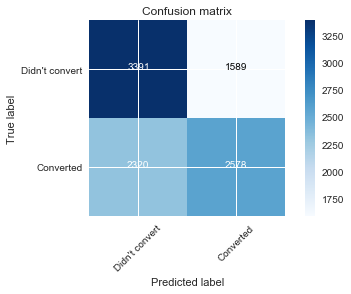

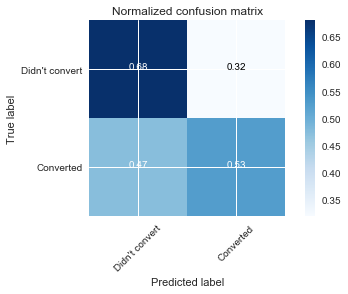

In [190]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = ["Didn't convert", "Converted"]
cnf_matrix = confusion_matrix(y_te, predicted_svm)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Random Forests

In [191]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[10,100,1000], 'n_jobs':[-1], 'max_features':['sqrt', 'log2'], 
              'max_depth': [5, 10, 15]} 
rf_gscv = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, cv=3, verbose=3)
rf_gscv.fit(X_tr, y_tr)
                           
print(rf_gscv.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] n_estimators=10, max_features=sqrt, max_depth=5, n_jobs=-1 ......
[CV] n_estimators=10, max_features=sqrt, max_depth=5, n_jobs=-1 ......
[CV] n_estimators=10, max_features=sqrt, max_depth=5, n_jobs=-1 ......
[CV] n_estimators=100, max_features=sqrt, max_depth=5, n_jobs=-1 .....
[CV] n_estimators=100, max_features=sqrt, max_depth=5, n_jobs=-1 .....
[CV] n_estimators=100, max_features=sqrt, max_depth=5, n_jobs=-1 .....
[CV] n_estimators=1000, max_features=sqrt, max_depth=5, n_jobs=-1 ....
[CV] n_estimators=1000, max_features=sqrt, max_depth=5, n_jobs=-1 ....
[CV]  n_estimators=10, max_features=sqrt, max_depth=5, n_jobs=-1, score=0.5895528054058158, total=   0.2s
[CV] n_estimators=1000, max_features=sqrt, max_depth=5, n_jobs=-1 ....
[CV]  n_estimators=10, max_features=sqrt, max_depth=5, n_jobs=-1, score=0.5869400151860289, total=   0.3s
[CV]  n_estimators=10, max_features=sqrt, max_depth=5, n_jobs=-1, score=0.59199635507631

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.2s


[CV]  n_estimators=100, max_features=sqrt, max_depth=10, n_jobs=-1, score=0.5876233864844344, total=   3.0s
[CV] n_estimators=1000, max_features=sqrt, max_depth=10, n_jobs=-1 ...
[CV]  n_estimators=100, max_features=sqrt, max_depth=10, n_jobs=-1, score=0.5948819196598071, total=   4.7s
[CV] n_estimators=1000, max_features=sqrt, max_depth=10, n_jobs=-1 ...
[CV]  n_estimators=1000, max_features=sqrt, max_depth=5, n_jobs=-1, score=0.5906916710955888, total=  11.1s
[CV] n_estimators=1000, max_features=sqrt, max_depth=10, n_jobs=-1 ...
[CV]  n_estimators=1000, max_features=sqrt, max_depth=5, n_jobs=-1, score=0.5877752467729689, total=  11.1s
[CV] n_estimators=10, max_features=log2, max_depth=10, n_jobs=-1 .....
[CV]  n_estimators=1000, max_features=sqrt, max_depth=5, n_jobs=-1, score=0.5926038423570507, total=  11.9s
[CV] n_estimators=10, max_features=log2, max_depth=10, n_jobs=-1 .....
[CV]  n_estimators=10, max_features=log2, max_depth=10, n_jobs=-1, score=0.5857565864399058, total=   0.6

[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  2.4min finished


{'n_estimators': 1000, 'n_jobs': -1, 'max_depth': 10, 'max_features': 'log2'}
CPU times: user 58.2 s, sys: 664 ms, total: 58.9 s
Wall time: 2min 35s


In [199]:
rf_gscv.best_score_

0.59162237408251073

### Plot train test error

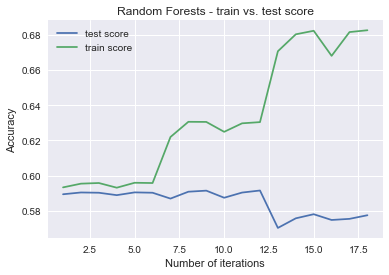

In [193]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot(range(1,19),rf_gscv.cv_results_['mean_test_score'], label='test score')
plt.plot(range(1,19),rf_gscv.cv_results_['mean_train_score'], label='train score')
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.title('Random Forests - train vs. test score')
plt.legend(loc='best')
plt.show()

## Cross validation

In [194]:
%%time
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

rf_model = rf_gscv.best_estimator_
predicted_rf = cross_val_predict(rf_model, X_te, y_te, cv=5, n_jobs=-1)
print(accuracy_score(y_te, predicted_rf))
print(classification_report(y_te, predicted_svm))

0.595869609233
             precision    recall  f1-score   support

          0       0.59      0.68      0.63      4980
          1       0.62      0.53      0.57      4898

avg / total       0.61      0.60      0.60      9878

CPU times: user 88.2 ms, sys: 43.5 ms, total: 132 ms
Wall time: 8.64 s


## Confusion Matrix

Confusion matrix, without normalization
[[3403 1577]
 [2415 2483]]
Normalized confusion matrix
[[ 0.68  0.32]
 [ 0.49  0.51]]


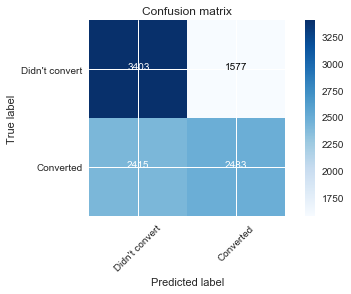

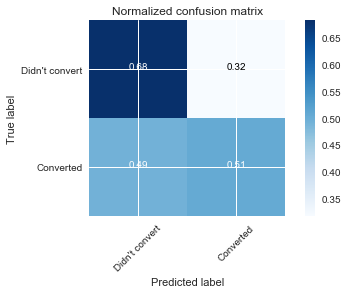

In [195]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = ["Didn't convert", "Converted"]
cnf_matrix = confusion_matrix(y_te, predicted_rf)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Result - All models have similar predictions, GBT seems to be the best model

# Way to improve prediction - Model stacking

### Create training and test data with 5 folds and 4 columns for predictions from each model

In [15]:
train_meta = pd.DataFrame(data=X_tr.toarray(), columns=X.columns)

In [16]:
train_meta['foldID'] = np.random.randint(low=1,high=6, size=(train_meta.shape[0],1))

In [17]:
train_meta['LR'] = np.nan
train_meta['SVM'] = np.nan
train_meta['GBT'] = np.nan
train_meta['RF'] = np.nan

In [18]:
train_meta['customer'] = y_tr.values.reshape(y_tr.shape[0],1)

In [19]:
test_meta = pd.DataFrame(data=X_te.toarray(), columns=X.columns)

In [20]:
test_meta['foldID'] = np.random.randint(low=1,high=6, size=(test_meta.shape[0],1))

In [21]:
test_meta['LR'] = np.nan
test_meta['SVM'] = np.nan
test_meta['GBT'] = np.nan
test_meta['RF'] = np.nan

In [22]:
test_meta['customer'] = y_te.values.reshape(y_te.shape[0],1)

# Calculate predictions for each fold

In [23]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

for i in range(1,6):
    X_train_test_fold = train_meta[train_meta['foldID'] == i].drop(['LR', 'SVM', 'GBT', 'RF', 'customer'], axis=1)
    y_train_test_fold = train_meta[train_meta['foldID'] == i]['customer']
    X_train_train_fold = train_meta[train_meta['foldID'] != i].drop(['LR', 'SVM', 'GBT', 'RF', 'customer'], axis=1)
    y_train_train_fold = train_meta[train_meta['foldID'] != i]['customer']
    # Calculate Logistic regression
    lr_m = LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)
    lr_m.fit(X_train_train_fold, y_train_train_fold)
    train_meta.loc[(train_meta['foldID'] == i),'LR'] = lr_m.predict(X_train_test_fold)
    
    # Gradient Boosted Trees
    gbt_m = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
    gbt_m.fit(X_train_train_fold, y_train_train_fold)
    train_meta.loc[(train_meta['foldID'] == i),'GBT'] = gbt_m.predict(X_train_test_fold)
    
    # SVM
    svm_m = SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
              max_iter=-1, probability=False, random_state=None, shrinking=True,
              tol=0.001, verbose=False)
    svm_m.fit(X_train_train_fold, y_train_train_fold)
    train_meta.loc[(train_meta['foldID'] == i),'SVM'] = svm_m.predict(X_train_test_fold)
    
    # RF
    rf_m = RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_depth=10, max_features='log2')
    rf_m.fit(X_train_train_fold, y_train_train_fold)
    train_meta.loc[(train_meta['foldID'] == i),'RF'] = rf_m.predict(X_train_test_fold)
    

CPU times: user 6min 25s, sys: 5.45 s, total: 6min 30s
Wall time: 5min 29s


### Fit full training model to test_meta for predictions

In [24]:
lr_m = LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)
lr_m.fit(X_tr,y_tr)
test_meta['LR'] = lr_m.predict(X_te)
    
    # Gradient Boosted Trees
gbt_m = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
gbt_m.fit(X_tr,y_tr)
test_meta['GBT'] = gbt_m.predict(X_te)
    
    # SVM
svm_m = SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
              max_iter=-1, probability=False, random_state=None, shrinking=True,
              tol=0.001, verbose=False)
svm_m.fit(X_tr,y_tr)
test_meta['SVM'] = svm_m.predict(X_te)
    
    # RF
rf_m = RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_depth=10, max_features='log2')
rf_m.fit(X_tr,y_tr)
test_meta['RF'] = svm_m.predict(X_te)

# Save train and test meta

In [25]:
train_meta.to_csv('train_meta', columns=train_meta.columns, sep=',')

In [26]:
test_meta.to_csv('test_meta', columns=test_meta.columns, sep=',')

# Read train and test_meta

In [88]:
train_meta = pd.read_csv('train_meta', index_col=0)

In [89]:
test_meta = pd.read_csv('test_meta', index_col=0)

,age,00 Organic,11 FB,12 PINTEREST,21 ASA,22 Adwords (Search),31 OUTBRAIN,32 Taboola,41 Youtube,42 Adcolony,...,FR,GB,MX,US,foldID,LR,SVM,GBT,RF,customer
0,-0.767046,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4,1,1,0,1,1
1,-0.014305,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,4,0,0,0,0,1
2,1.491177,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,4,0,0,0,0,1
3,2.076642,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2,1,1,1,1,1
4,0.822074,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,4,0,0,0,0,1
5,-0.181581,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2,1,1,1,1,0
6,-0.348856,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1,1,1,1,1,0
7,-1.017959,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,4,0,0,0,0,1
8,1.574814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,4,0,0,0,0,0
9,0.236609,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2,0,0,0,0,1


# Calculate predictions ons stacked model

# Logistic regression - GridSearchCV to find optimal parameters

In [27]:
X_train = train_meta.drop('customer', axis=1)
y_train = train_meta['customer']
X_test = test_meta.drop(['LR', 'SVM', 'GBT', 'RF', 'customer'], axis=1)
y_test = test_meta['customer']

# Cross validation

In [28]:
%%time
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)
lr_model.fit(X_train, y_train)
predicted_lr = cross_val_predict(lr_model, X_test, y_test, cv=5, n_jobs=-1)
print(accuracy_score(y_test, predicted_lr))
print(classification_report(y_test, predicted_lr))

0.593946142944
             precision    recall  f1-score   support

          0       0.58      0.63      0.61      4898
          1       0.61      0.56      0.58      4980

avg / total       0.59      0.59      0.59      9878

CPU times: user 620 ms, sys: 44.2 ms, total: 664 ms
Wall time: 1.02 s


# Confusion Matrix

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[3091 1807]
 [2204 2776]]
Normalized confusion matrix
[[ 0.63  0.37]
 [ 0.44  0.56]]


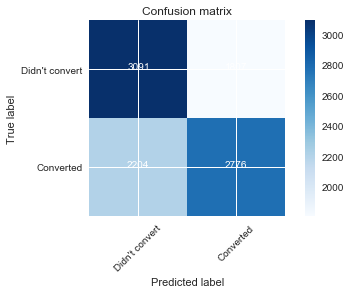

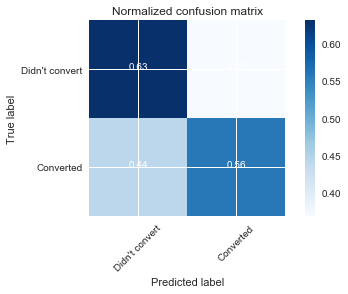

In [37]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = ["Didn't convert", "Converted"]
cnf_matrix = confusion_matrix(y_test, predicted_lr)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Gradient Boosted Trees - GridSearchCV to find optimal parameters

# Cross validation

In [43]:
%%time
from sklearn import ensemble
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

gbt_model = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
gbt_model.fit(X_train, y_train)
predicted_gbt = cross_val_predict(gbt_model, X_test, y_test, cv=5, n_jobs=-1)
print(accuracy_score(y_test, predicted_gbt))
print(classification_report(y_test, predicted_gbt))

0.593541202673
             precision    recall  f1-score   support

          0       0.59      0.62      0.60      4898
          1       0.60      0.57      0.59      4980

avg / total       0.59      0.59      0.59      9878

CPU times: user 1.79 s, sys: 52.9 ms, total: 1.85 s
Wall time: 2.44 s


# Confusion Matrix

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[3025 1873]
 [2142 2838]]
Normalized confusion matrix
[[ 0.62  0.38]
 [ 0.43  0.57]]


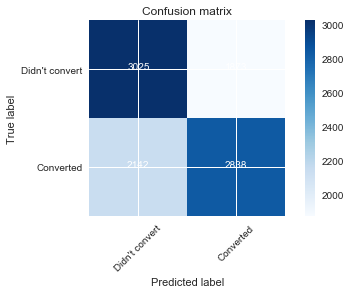

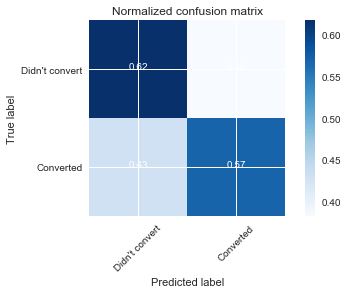

In [44]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = ["Didn't convert", "Converted"]
cnf_matrix = confusion_matrix(y_test, predicted_gbt)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# SVM

## Cross validation

In [39]:
%%time
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

svm_model = SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
              max_iter=-1, probability=False, random_state=None, shrinking=True,
              tol=0.001, verbose=False)
svm_model.fit(X_train, y_train)
predicted_svm = cross_val_predict(svm_model, X_test, y_test, cv=5, n_jobs=-1)
print(accuracy_score(y_test, predicted_svm))
print(classification_report(y_test, predicted_svm))

0.58898562462
             precision    recall  f1-score   support

          0       0.58      0.60      0.59      4898
          1       0.60      0.58      0.59      4980

avg / total       0.59      0.59      0.59      9878

CPU times: user 1min 37s, sys: 2.26 s, total: 1min 40s
Wall time: 1min 45s


## Confusion Matrix

Confusion matrix, without normalization
[[2950 1948]
 [2112 2868]]
Normalized confusion matrix
[[ 0.6   0.4 ]
 [ 0.42  0.58]]


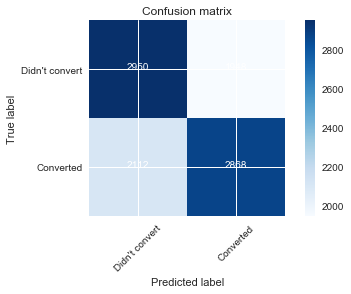

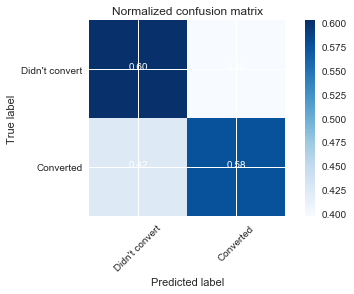

In [40]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = ["Didn't convert", "Converted"]
cnf_matrix = confusion_matrix(y_test, predicted_svm)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Random Forests

## Cross validation

In [41]:
%%time
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_depth=10, max_features='log2')
rf_model.fit(X_train, y_train)
predicted_rf = cross_val_predict(rf_model, X_test, y_test, cv=5, n_jobs=-1)
print(accuracy_score(y_test, predicted_rf))
print(classification_report(y_test, predicted_svm))

0.588580684349
             precision    recall  f1-score   support

          0       0.58      0.60      0.59      4898
          1       0.60      0.58      0.59      4980

avg / total       0.59      0.59      0.59      9878

CPU times: user 18 s, sys: 643 ms, total: 18.6 s
Wall time: 8.75 s


## Confusion Matrix

Confusion matrix, without normalization
[[3014 1884]
 [2180 2800]]
Normalized confusion matrix
[[ 0.62  0.38]
 [ 0.44  0.56]]


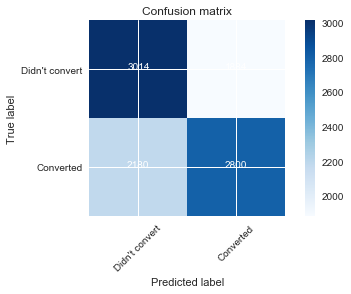

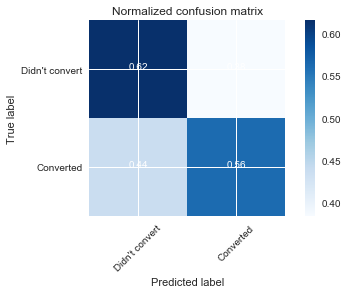

In [42]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = ["Didn't convert", "Converted"]
cnf_matrix = confusion_matrix(y_test, predicted_rf)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Result -> No large improvement through model stacking, GBT still best model

# Create final predictions

In [59]:
test = pd.read_csv('test_data.csv.csv_fixed')

### Convert test set

In [60]:
channel = pd.get_dummies(test['channel'])
os = pd.get_dummies(test['os'], drop_first=True)
gender = pd.get_dummies(test['gender'], drop_first=True)
country = pd.get_dummies(test['country'])

In [61]:
test.drop(['user_id','channel','os','gender','country'],axis=1,inplace=True)

In [62]:
# add dummy variable encoding to training matrix
test = pd.concat([test,channel,os,gender,country],axis=1)

In [63]:
test.head()

,age,00 Organic,11 FB,12 PINTEREST,21 ASA,22 Adwords (Search),31 OUTBRAIN,32 Taboola,41 Youtube,42 Adcolony,...,ios,male,AU,CA,DE,ES,FR,GB,MX,US
0,32,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,27,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,36,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0
3,29,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
4,20,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


### Fit Standard scaler to age

In [64]:
age = test['age'].values.reshape(test.shape[0],1)

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(age)
scaled_data = scaler.transform(age)

/Users/jzawadzki/anaconda/envs/p3env/lib/python3.5/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [66]:
test['age'] = scaled_data

In [79]:
test.columns

Index(['age', '00 Organic', '11 FB', '12 PINTEREST', '21 ASA',
       '22 Adwords (Search)', '31 OUTBRAIN', '32 Taboola', '41 Youtube',
       '42 Adcolony', '61 Web/Content', '62 Social Media', '69 Others',
       '95 LAT', 'ios', 'male', 'AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'MX',
       'US'],
      dtype='object')

In [78]:
test.drop(['LR', 'SVM', 'GBT', 'RF'], axis=1, inplace=True)

### Add model prediction columns

In [70]:
test_train_meta = pd.DataFrame(data=test, columns=test.columns)

In [71]:
test_train_meta['LR'] = np.nan
test_train_meta['SVM'] = np.nan
test_train_meta['GBT'] = np.nan
test_train_meta['RF'] = np.nan

### Add predictions to test_train_meta, fitting on original training data

In [81]:
lr_m = LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)
lr_m.fit(X_tr,y_tr)
test_train_meta['LR'] = lr_m.predict(test)
    
    # Gradient Boosted Trees
gbt_m = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
gbt_m.fit(X_tr,y_tr)
test_train_meta['GBT'] = gbt_m.predict(test)
    
    # SVM
svm_m = SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
              max_iter=-1, probability=False, random_state=None, shrinking=True,
              tol=0.001, verbose=False)
svm_m.fit(X_tr,y_tr)
test_train_meta['SVM'] = svm_m.predict(test)
    
    # RF
rf_m = RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_depth=10, max_features='log2')
rf_m.fit(X_tr,y_tr)
test_train_meta['RF'] = svm_m.predict(test)

In [83]:
test_train_meta.head()

,age,00 Organic,11 FB,12 PINTEREST,21 ASA,22 Adwords (Search),31 OUTBRAIN,32 Taboola,41 Youtube,42 Adcolony,...,DE,ES,FR,GB,MX,US,LR,SVM,GBT,RF
0,0.067396,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,-0.356694,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.406669,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,1,1
3,-0.187058,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,-0.950420,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Fit best classifier on stacked training model

In [85]:
from sklearn.ensemble import GradientBoostingClassifier

gbt_model = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
gbt_model.fit(X_train.drop(['foldID'], axis=1),y_train)

predicted_gbt = gbt_model.predict(test_train_meta)

In [92]:
final_prediction = pd.DataFrame(data=predicted_gbt, columns=['customer'])

# Save predictions

In [95]:
final_prediction.to_csv('zawadzki_jan_predictions.csv', index=False)

---

# Predict just from predicted columns

In [110]:
train_meta

,age,00 Organic,11 FB,12 PINTEREST,21 ASA,22 Adwords (Search),31 OUTBRAIN,32 Taboola,41 Youtube,42 Adcolony,...,FR,GB,MX,US,foldID,LR,SVM,GBT,RF,customer
0,0.152971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,3,1.0,0.0,0.0,0.0,0
1,1.240263,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2,1.0,1.0,1.0,1.0,1
2,-0.432494,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,4,0.0,0.0,0.0,0.0,0
3,0.822074,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2,1.0,1.0,1.0,1.0,1
4,-0.767046,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2,0.0,0.0,0.0,0.0,1
5,-1.101597,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0,0.0,0
6,0.069333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,4,1.0,1.0,1.0,1.0,1
7,-1.436148,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2,0.0,0.0,0.0,0.0,0
8,1.491177,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,5,1.0,1.0,1.0,1.0,0
9,1.491177,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3,1.0,1.0,1.0,1.0,1


In [111]:
X_tr_new = train_meta[['LR', 'SVM', 'GBT', 'RF']]
y_tr_new = train_meta['customer']
X_te_new = test_meta[['LR', 'SVM', 'GBT', 'RF']]
y_te_new = test_meta['customer']

In [112]:
%%time
from sklearn import ensemble
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

gbt_model = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
gbt_model.fit(X_tr_new, y_tr_new)
predicted_gbt = cross_val_predict(gbt_model, X_te_new, y_te_new, cv=5, n_jobs=-1)
print(accuracy_score(y_te_new, predicted_gbt))
print(classification_report(y_te_new, predicted_gbt))

0.594351083215
             precision    recall  f1-score   support

          0       0.58      0.66      0.62      4898
          1       0.61      0.53      0.57      4980

avg / total       0.60      0.59      0.59      9878

CPU times: user 1.88 s, sys: 87.5 ms, total: 1.97 s
Wall time: 2.27 s


# Confusion Matrix

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[3222 1676]
 [2331 2649]]
Normalized confusion matrix
[[ 0.66  0.34]
 [ 0.47  0.53]]


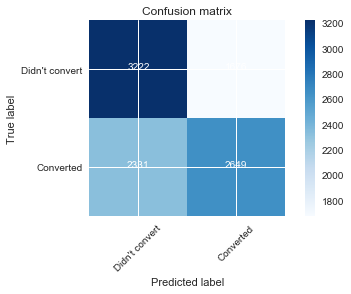

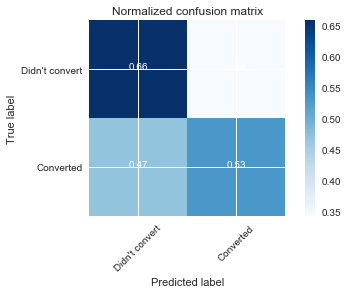

In [113]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = ["Didn't convert", "Converted"]
cnf_matrix = confusion_matrix(y_te_new, predicted_gbt)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [97]:
y_train

0        0
1        1
2        0
3        1
4        1
5        0
6        1
7        0
8        0
9        1
10       1
11       1
12       0
13       1
14       0
15       1
16       1
17       1
18       1
19       0
20       1
21       0
22       0
23       0
24       1
25       1
26       0
27       0
28       0
29       1
        ..
39480    0
39481    0
39482    1
39483    1
39484    0
39485    0
39486    0
39487    1
39488    0
39489    1
39490    0
39491    0
39492    1
39493    0
39494    1
39495    0
39496    0
39497    1
39498    0
39499    0
39500    1
39501    0
39502    0
39503    1
39504    0
39505    0
39506    0
39507    0
39508    1
39509    0
Name: customer, Length: 39510, dtype: int64

# Implement majority voting

In [115]:
X_tr_new_sum = X_tr_new

In [116]:
X_tr_new_sum.loc['sum'] = X_tr_new.sum()

/Users/jzawadzki/anaconda/envs/p3env/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [127]:
X_tr_new_sum['sum'] = X_tr_new_sum.drop('sum', axis=1).sum(axis=0)

/Users/jzawadzki/anaconda/envs/p3env/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [123]:
X_tr_new_sum.loc[0, 'sum']

nan

In [128]:
X_tr_new_sum

,LR,SVM,GBT,RF,sum
0,1.0,0.0,0.0,0.0,NaN
1,1.0,1.0,1.0,1.0,NaN
2,0.0,0.0,0.0,0.0,NaN
3,1.0,1.0,1.0,1.0,NaN
4,0.0,0.0,0.0,0.0,NaN
5,0.0,0.0,0.0,0.0,NaN
6,1.0,1.0,1.0,1.0,NaN
7,0.0,0.0,0.0,0.0,NaN
8,1.0,1.0,1.0,1.0,NaN
9,1.0,1.0,1.0,1.0,NaN
